In [1]:
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

data = pd.read_csv('../Emotion_classify_Data.csv', encoding='latin-1')

def cleaning(value):
    punctuation_cleaning = []
    stopwords_cleaning_string = ''
    
    for i in value:
        if i not in string.punctuation:
            punctuation_cleaning.append(i)
    punctuation_cleaning = "".join(punctuation_cleaning).split()
    
    stopwords_list = ["a", "an", "the", "in", "on", "at", "is", "it", "and", "to", "of"]
    for j in punctuation_cleaning:
        if j.lower() not in stopwords_list:
            stopwords_cleaning_string += j.lower() + ' '
    
    return stopwords_cleaning_string

data['Cleaned_Comment'] = data['Comment'].apply(cleaning)

2024-12-28 09:44:59.718648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 09:44:59.726214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735379099.734936  358038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735379099.737812  358038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 09:44:59.748673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
label_encoder = LabelEncoder()
data['Emotion_Label'] = label_encoder.fit_transform(data['Emotion'])

In [3]:
X = data['Cleaned_Comment']
y = data['Emotion_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
maxlen = int(np.ceil(np.mean([len(x) for x in X_train_seq])))
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
total_words = len(tokenizer.word_index) + 1

In [5]:
print("Навчання моделі з нуля...")
model_scratch = Sequential()
model_scratch.add(Embedding(total_words, 32, input_length=maxlen))
model_scratch.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_scratch.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_scratch.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history_scratch = model_scratch.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

Навчання моделі з нуля...


/home/user/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1735379101.630764  358038 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3665 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.3334 - loss: 1.0984 - val_accuracy: 0.3600 - val_loss: 1.0937
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.4596 - loss: 1.0376 - val_accuracy: 0.6253 - val_loss: 0.8030
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.7451 - loss: 0.6387 - val_accuracy: 0.8242 - val_loss: 0.5058
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9093 - loss: 0.3251 - val_accuracy: 0.8411 - val_loss: 0.4487
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9483 - loss: 0.2052 - val_accuracy: 0.8232 - val_loss: 0.4763
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9655 - loss: 0.1505 - val_accuracy: 0.8484 - val_loss: 0.4461
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9734 - loss: 0.1041 - val_accuracy: 0.8358 - val_loss: 0.4745
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9771 - loss: 0.1007 - val_acc

In [6]:
print("Завантаження pretrained embeddings...")
embedding_dim = 50
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < total_words:
        embedding_matrix[i] = np.random.rand(embedding_dim)

Завантаження pretrained embeddings...


In [7]:
model_pretrained = Sequential()
model_pretrained.add(Embedding(
    total_words,
    embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False
))
model_pretrained.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_pretrained.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_pretrained.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history_pretrained = model_pretrained.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.3353 - loss: 1.1095 - val_accuracy: 0.3284 - val_loss: 1.0996
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3256 - loss: 1.1028 - val_accuracy: 0.3600 - val_loss: 1.0988
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.3349 - loss: 1.1004 - val_accuracy: 0.3558 - val_loss: 1.0984
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3529 - loss: 1.1005 - val_accuracy: 0.3558 - val_loss: 1.0990
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3364 - loss: 1.0983 - val_accuracy: 0.3389 - val_loss: 1.0985
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3483 - loss: 1.0979 - val_accuracy: 0.3495 - val_loss: 1.0978
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3547 - loss: 1.0982 - val_accuracy: 0.3389 - val_loss: 1.0988
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.3453 - loss: 1.0950 - val_accu

In [8]:
print("Оцінка моделі з нуля:")
results_scratch = model_scratch.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss: {results_scratch[0]}, Accuracy: {results_scratch[1]}")

print("Оцінка моделі з pretrained embeddings:")
results_pretrained = model_pretrained.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss: {results_pretrained[0]}, Accuracy: {results_pretrained[1]}")

Оцінка моделі з нуля:
Loss: 0.48217660188674927, Accuracy: 0.8560606241226196
Оцінка моделі з pretrained embeddings:
Loss: 1.098091721534729, Accuracy: 0.33838382363319397


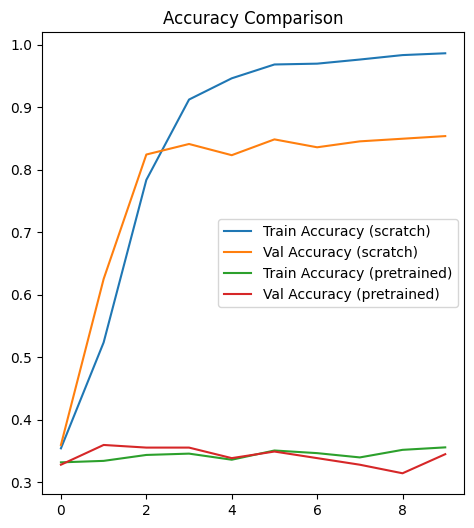

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'], label='Train Accuracy (scratch)')
plt.plot(history_scratch.history['val_accuracy'], label='Val Accuracy (scratch)')
plt.plot(history_pretrained.history['accuracy'], label='Train Accuracy (pretrained)')
plt.plot(history_pretrained.history['val_accuracy'], label='Val Accuracy (pretrained)')
plt.title('Accuracy Comparison')
plt.legend()

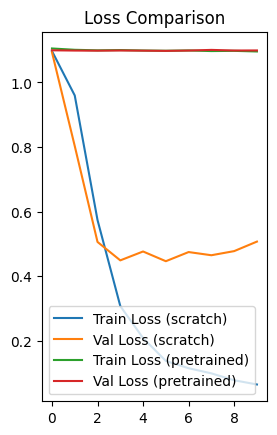

In [10]:
plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'], label='Train Loss (scratch)')
plt.plot(history_scratch.history['val_loss'], label='Val Loss (scratch)')
plt.plot(history_pretrained.history['loss'], label='Train Loss (pretrained)')
plt.plot(history_pretrained.history['val_loss'], label='Val Loss (pretrained)')
plt.title('Loss Comparison')
plt.legend()

plt.show()